# Fourier Transforms / Matched Filters

### Problem 1 - Writing a function that will shift an array by an arbitrary amount using convolution

We know that the Fourier Transform of $f(x)$ is given as,

$$ F(k) = \sum f(x) e^\frac{-2\pi i k x}{N}$$

If $x$ is shifted by $dx$, then the FFT of $f(x+dx)$ is given as,

$$ \sum f(x+dx)e^\frac{-2\pi i k x}{N}$$

Let $x^* = x + dx$. Then

$$ F(k) = \sum f(x^*)e^\frac{-2\pi i k (x^* - dx)}{N}$$
 
$$ F(k) = e^\frac{2\pi i k dx}{N} * \sum f(x^*)e^\frac{-2\pi i k x^*}{N} ............ (1)$$



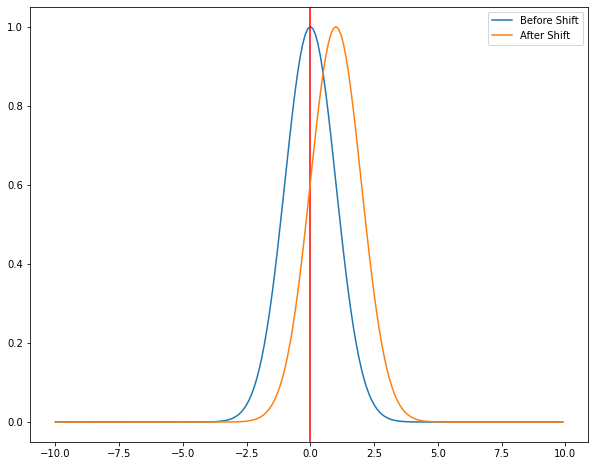

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def shift(x,y,dx,plot=True):   # x is an array, dx is the amount of shift
    
    N = len(x)  # The total no. of samples
    k = np.arange(N)
    y_ft = np.fft.fft(y)
    # Equation (1) seen above is applied below! We do convolution here in Fourier Space
    yft_new = y_ft * np.exp(-2*np.pi*1J*k*dx/N)   
    y_shift = np.real(np.fft.ifft(yft_new))  # And Inverse Fourier Transform back to the  real space
    if plot is True:
        plt.figure(figsize=(10,8))
        plt.plot(x,y,label='Before Shift')
        plt.axvline(x[np.argmax(y)],color='r')
        plt.plot(x,y_shift,label='After Shift')
        plt.legend()
        plt.show()
    
    return y_shift
    
# Let's see this in action...
x = np.arange(-10,10,0.1)
y = np.exp(-0.5*x**2 / (1.0**2))  # We are plotting a Gaussian here with sigma = 1.0
dy = 10.0  # shifting by half the length of the array
y_shift = shift(x,y,dy)

### Problem 2 - The Correlation Function

The correlation function in discrete limit is given as,
$$ f \star g = \sum f(x) * g(y+x) ............ (1)$$

Let's swap $f(x)$ and $ g(y+x)$ in the above equation with their  Inverse Fourier Transform and see what happens!

$$ f(x) = \frac{1}{N} \sum F(k) e^{\frac{2\pi i k x}{N}}$$

$$ g(y+x) = \frac{1}{N} \sum G(k^{'}) e^{\frac{2\pi i k^{'} (y+x)}{N}}$$

Thus, Equation $(1)$ becomes,

$$ h(x) = \frac{1}{N^2} \sum_{x=0}^{N-1} \sum_k F(k) e^{\frac{2\pi i k x}{N}} \sum_{k^{'}} G(k^{'}) e^{\frac{2\pi i k^{'} (x+y)}{N}}$$ 

Let's reorder the sums,

$$ h(x) = \frac{1}{N^2} \sum_k \sum_{k^{'}} F(k)G(k^{'}) e^{\frac{2\pi i k^{'} y}{N}} \sum_x     e^{\frac{2\pi i (k + k^{'}) x}{N}}  $$ 

Now, in the above equation, the sum of $x$ is zero unless $ k = -k^{'}$. Hence, we can replace the double sum with a single sum and give a flip sign as follow,

$$ h(x) = \frac{1}{N} \sum_k F(-k) G(k) e^{\frac{2\pi i k y}{N}} ...... (2) $$

We know that $ F(-k) = F^{*}(k) $ if $F$ is real, from the properties of DFT. Thus, Equation $(2)$ just the inverse DFT of conjugate of F times the G.

Thus, $ f \star g =$ Inverse DFT of $(F^{*}(k) * G(k))$

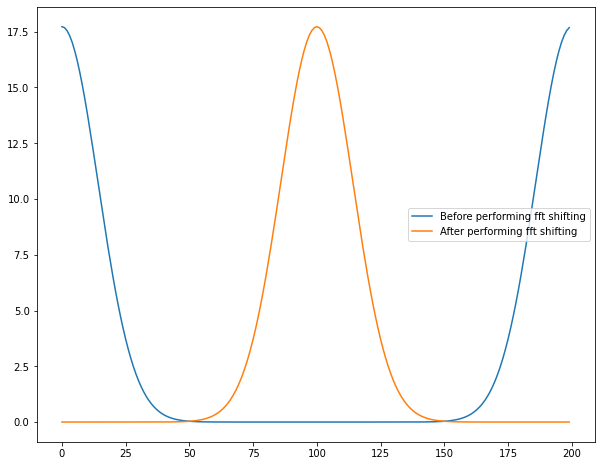

In [34]:
def correlate(x,y):
    x_ft = np.fft.fft(x)
    y_ft = np.fft.fft(y)
    
    h = np.fft.ifft(np.conj(x_ft)*y_ft)
    return h

# Let's take a Gaussian and correlate with itself

x = np.arange(-10,10,0.1)
fun = np.exp(-0.5*x**2 / (1.0**2))  # This is our Gaussian Function with sigma = 1.0
h = correlate(fun,fun)
plt.figure(figsize=(10,8))
plt.plot(np.real(h),label='Before performing fft shifting')
plt.plot(np.fft.fftshift(np.real(h)),label='After performing fft shifting') # Bring the edges to the center to see the Gaussian
plt.legend()
plt.show()

We see that the correlation of a Gaussian with itself yeilds a Gaussian! Let's use the 'shift' function defined in problem 1 to perform the correlation of a Gaussian shifted by an arbitrary amount by itself

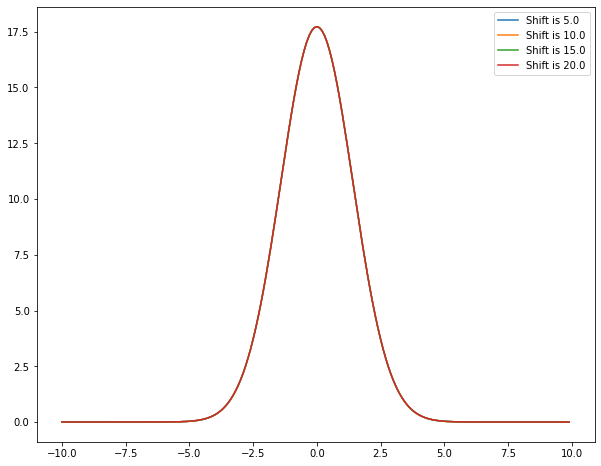

In [35]:
# Now, Let's do correlation on this shifted Gaussian
plt.figure(figsize=(10,8))
def shift_correlate(x,fun,dx):
    for i in dx:
        fun_shift = shift(x,fun,i,False)   # This is my Shifted Gaussian
        h = correlate(fun_shift,fun_shift) # Performing correlation on the shifted Gaussian
        plt.plot(x,np.fft.fftshift(np.real(h)),label=f'Shift is {i}') # We do this to bring the edges to the center
        plt.legend()
    plt.show()

dx = [5.0,10.0,15.0,20.0]  # Amount of shift...
shift_correlate(x,fun,dx)

Suprisingly, we see that the correlation function does not depend on the shift of the Gaussian! Let's see this mathematically. We know from problem 1 that for a function $f(x)$, if $x$ is shifted by $dx$, then the FFT of $f(x+dx)$ is given as,

$$ F(k) = e^\frac{2\pi i k dx}{N} * \sum f(x)e^\frac{-2\pi i k x}{N} .... (1)$$

Let's perform correlation on equation (1) by itself. Thus,

$$ H(k) = F^{*}(k) * F(k) $$

Thus, the phase ramps goes off due to its own conjugate and we end up with the unshifted gaussian

### Problem 3 - Circulant Nature of DFT

Let's see how to implement FFT based convolution. The convolution function in discrete limit is given as,

$$ f \bigotimes g = \sum f(x) * g(y - x) ............ (1)$$

Let's swap $f(x)$ and $ g(y - x)$ in the above equation with their  Inverse Fourier Transform and see what happens!

$$ f(x) = \frac{1}{N} \sum F(k) e^{\frac{2\pi i k x}{N}}$$

$$ g(y - x) = \frac{1}{N} \sum G(k^{'}) e^{\frac{2\pi i k^{'} (y - x)}{N}}$$

Thus, Equation $(1)$ becomes,

$$ h(x) = \frac{1}{N^2} \sum_{x=0}^{N-1} \sum_k F(k) e^{\frac{2\pi i k x}{N}} \sum_{k^{'}} G(k^{'}) e^{\frac{2\pi i k^{'} (y - x)}{N}}$$ 

Let's reorder the sums,

$$ h(x) = \frac{1}{N^2} \sum_k \sum_{k^{'}} F(k)G(k^{'}) e^{\frac{2\pi i k^{'} y}{N}} \sum_x     e^{\frac{2\pi i (k - k^{'}) x}{N}}  $$ 

Now, in the above equation, the sum of $x$ is zero unless $ k = k^{'}$. Hence, we can replace the double sum with a single sum.

$$ h(x) = \frac{1}{N} \sum_k F(k) G(k) e^{\frac{2\pi i k y}{N}} ...... (2) $$

 Thus, Equation $(2)$ just the inverse DFT of F times the G.

Thus, $ f \bigotimes g = F(k) * G(k)$

So, to convolve 2 functions in real space, we just multiply our function in fourier space and inverse fourier transform back to the real space.
Discrete Fourier Transforms are periodic in nature. Let's say we have,

$$ f(x) = \sum F(k) e^{\frac{2\pi i k x}{N}}$$

Now, $f(x+N)$ is written as,

$$ f(x+N) = \sum F(k) e^{\frac{2\pi i k (x+N)}{N}}$$

$$ f(x+N) = \sum F(k) e^{2\pi i k} e^{\frac{2\pi i k x}{N}}$$

For any integer $k$, $e^{2\pi i k}$ is $1$. Hence,

$$ f(x+N) = \sum F(k) e^{\frac{2\pi i k x}{N}} = f(x)$$

Thus, DFTs just wraps around. In this problem, to avoid this perodic nature, we just add zeros to the end of our input arrays

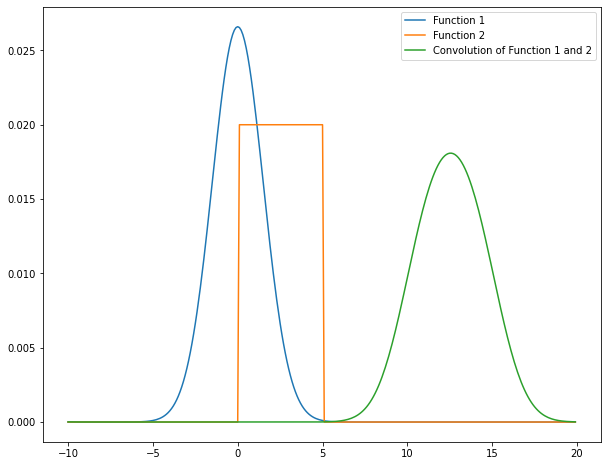

In [26]:
def convolution(f,g):
    F = np.fft.rfft(f)
    G = np.fft.rfft(g)
    H = F * G
    h = np.fft.irfft(H)

    return h

x = np.arange(-10,20,0.1)
# This function returns a gaussian with peak at x=0 and zeros at the end of the array
f = np.exp(-0.5*x**2 / 1.5**2)
# This function returns 1 from x > 0 to x < 5 and 0 everywhere.Thus, we have zeros at the end of this input array
g = 0*x; g[(x>0) & (x<5)]=1    
# Normalise f and g
f = f/f.sum()
g = g/g.sum()
h = convolution(f,g)

plt.figure(figsize=(10,8))
plt.plot(x,f)
plt.plot(x,g)
plt.plot(x,h)
plt.legend(['Function 1','Function 2','Convolution of Function 1 and 2'])
plt.show()

### Problem 4 

### (a) Show that $ \sum_{x=0}^{N-1} e^{\frac{-2\pi i k x}{N}} = \frac{1 - e^{-2\pi i k}}{1 - e^{\frac{-2\pi i k}{N}} }$

So, we have our LHS as,

$$ \sum_{x=0}^{N-1} e^{\frac{-2\pi i k x}{N}} .......... (1)$$

Let us consider $\alpha = e^{\frac{-2\pi i k}{N}} $. Then Equation (1) becomes,

$$ \sum_{x=0}^{N-1} \alpha^x ............ (2)$$

Equation (2) can be treated as a sum of geometric series. We know that the sum of a geometric series is given as,

$$ S_n = a\left(\frac{1 - r^n}{1 - r}\right) $$

In our case, 

## $ a = e^{\frac{-2\pi i k * 0}{N}} = 1 $

## $ r = \frac{e^{\frac{-2\pi i k * 1}{N}}}{e^{\frac{-2\pi i k * 0}{N}}} = \frac{e^{\frac{-2\pi i k }{N}}}{1} = e^{\frac{-2\pi i k }{N}} $

Hence, $$S_n = 1\left(\frac{1 - (e^{\frac{-2\pi i k }{N}})^N}{1 - e^{\frac{-2\pi i k }{N}}}\right) = \frac{1 - e^{-2\pi i k}}{1 - e^{\frac{-2\pi i k}{N}} }$$

### (b) Show that

### (i) As $k$ approaches 0,

## $$ \sum_{x=0}^{N-1} e^{\frac{-2\pi i x *0}{N}} = \sum_{x=0}^{N-1} 1 = N$$ 

As we have the sum over $N$ samples, we get $N$

### (ii) For any integer of $k$ that is not a multiple of $N$,

From (a), we have,

$$ \sum_{x=0}^{N-1} e^{\frac{-2\pi i k x}{N}} = \sum_{x=0}^{N-1} \left(e^{\frac{-2\pi i x}{N}}\right)^k =
\frac{1 - \left(e^{\frac{-2\pi i x }{N}}\right)^N}{1 - e^{\frac{-2\pi i x }{N}}} $$

Thus, the $N$ in the numerator cancels out and gives $\frac{1 - e^{-2\pi i x}}{1 - e^{\frac{-2\pi i x }{N}}}$

Since for integral multiplt of 2 $\pi$, the exponent evaluates to 1 for any value of x, the above equation becomes
 
$$ \frac{1 - 1}{1 - e^{\frac{-2\pi i x }{N}}} = 0 $$


Thus from (i) and (ii) we can conclude that, $$ \sum_{x=0}^{N-1} e^{\frac{-2\pi i x k}{N}} =\begin{cases}
    N & \text{if $k = 0$} \\
    0 & \text{if $k \neq 0$}
  \end{cases}
 $$

### (c) DFT of a non-integer sine wave

The DFT of a function $f(x)$ is given as,

$$ F(k) = \sum_{x=0}^{N-1} f(x) e{^\frac{2 \pi i k x}{N}}$$

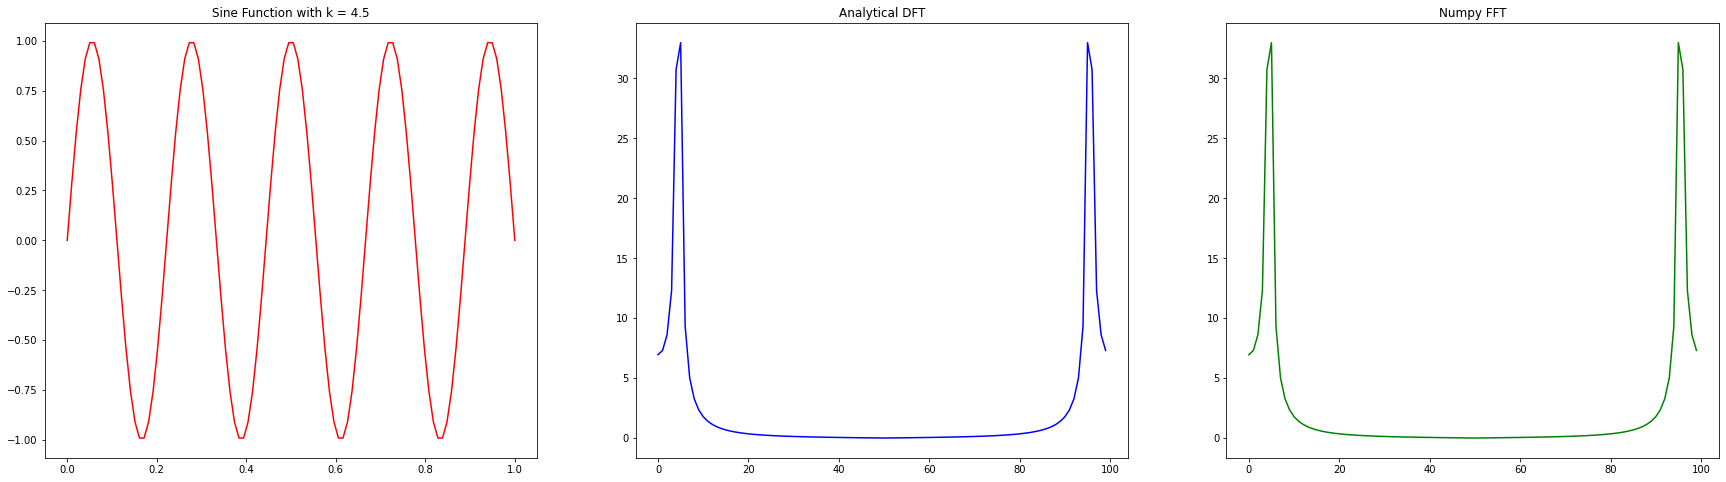

The delta function for the Analytical DFT occurs at 4.0 which is almost close to our frequency!
The delta function for the Analytical DFT occurs at 4.0 which is almost close to our frequency!

 The difference between the Analytical DFT and Numpy FFT is 6.696706469910069e-14


In [218]:
x = np.linspace(0,1,100)
freq = 4.5                  # We pick a non-integer value of k
f = np.sin(2*np.pi*freq*x)  # Our since function

# calculate the frequency
n = np.arange(N)
sr = 100   # Sampling rate
T = N/sr
freq = n/T 

plt.figure(figsize=(30,8))
plt.subplot(1, 3, 1)
plt.plot(x, f, 'r')
plt.title('Sine Function with k = 4.5')

# Let's do DFT on our function analytically
def DFT(f):
    N = len(f)
    x = np.arange(N)
    k = n.reshape((N, 1))
    f_dft = np.exp(-2J * np.pi * k * x / N)

    X = np.dot(f_dft, f)
    return X

f_dft = DFT(f)
plt.subplot(1, 3, 2)
plt.plot(freq, abs(f_dft),'b')
plt.title('Analytical DFT')

# Let's try the same with numpy' FFT module and compare it
f_fft =  np.fft.fft(f)
plt.subplot(1, 3, 3)
plt.plot(freq,np.abs(f_fft), 'g')
plt.title('Numpy FFT')
plt.show()

print(f'The delta function for the Analytical DFT occurs at',freq[np.argmax((f_dft))],'which is almost close to our frequency!')
print(f'The delta function for the Analytical DFT occurs at',freq[np.argmax((f_fft))],'which is almost close to our frequency!')

print('\n The difference between the Analytical DFT and Numpy FFT is',np.std(np.abs(f_dft)-np.abs(f_fft)))

The fourier transform of a sine wave is yeilding us almost a 'delta function' as seen above. But, it varies from the regular delta function due to a non-integer frequency. Also, the Numpy's FFT agrees to within the machine precision ($\text{(i.e.) Error} = 6.696706469910069e-14$) with the analytical DFT.

### (d) Window Function

In order to avoid the sharp jumps at the end of the intervals, we multiply our function with a window function that goes to zero at the edges. This cancels the jumps and prevents the leakage from the edges of the interval.

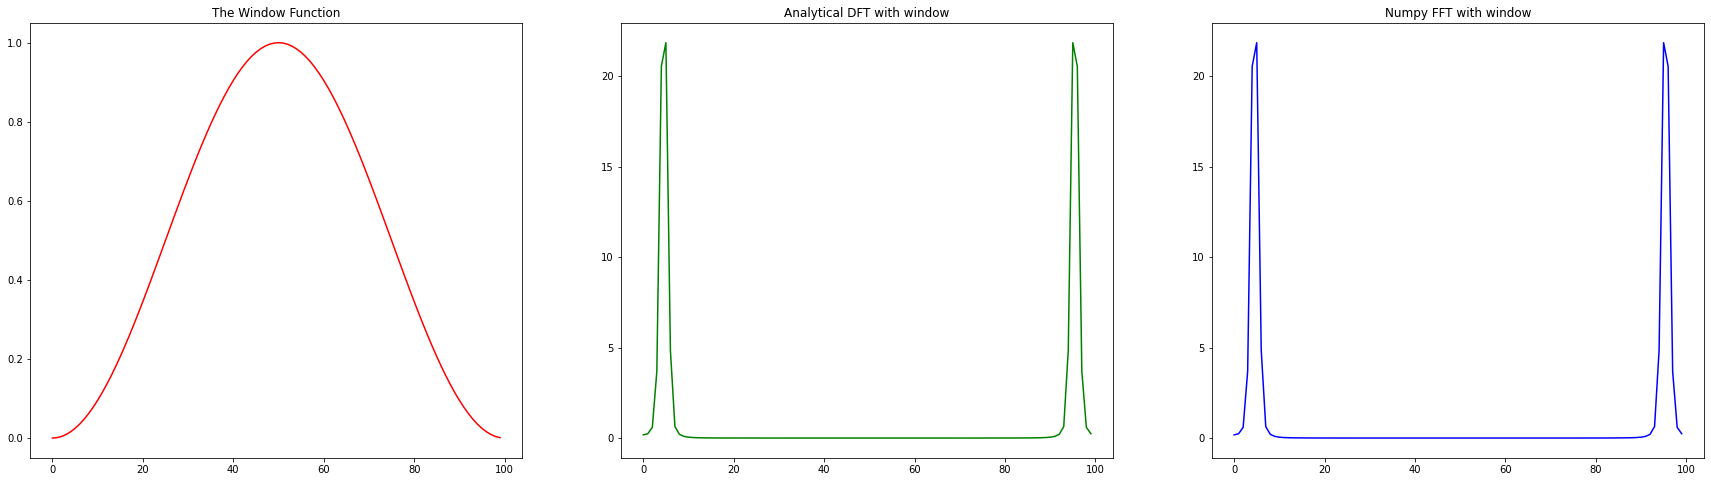

In [203]:
N = len(f)
x = np.arange(N)
# The window function we use here is
window = 0.5 - (0.5*np.cos(2*np.pi*x/N))
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.plot(x,window, 'r')
plt.title('The Window Function')

# Now, let's multiply our sine function from (c) with this window and perform DFT and numpy's FFT
f_dft_win = DFT(f*window)   # DFT Function from (c)
plt.subplot(1,3,2)
plt.plot(np.abs(f_dft_win), 'g')
plt.title('Analytical DFT with window')

f_fft_win =  np.fft.fft(f*window)  # Numpy's FFT
plt.subplot(1,3,3)
plt.plot(np.abs(f_fft_win), 'b')
plt.title('Numpy FFT with window')
plt.show()

Thus, by using a window function, the spectral leakage from the edge of the intervals dropped and we get a nice delta function for the FFT of our sine wave!

### (e) Show that Fourier Transform of the window is [N/2, -N/4, 0..... -N/4]

In [226]:
# Let's take the fourier transform of our window function using our 'DFT' function from (c)

win_fft = DFT(window)
print('The Fourier Transform of the window function comes as\n[',np.real(win_fft[0]),',',
      np.real(win_fft[1]),',',np.real(win_fft[2]),'....',np.real(win_fft[-1]),']')

The Fourier Transform of the window function comes as
[ 50.0 , -24.999999999999996 , -3.3059492643428e-15 .... -25.00000000000034 ]


Our $N$ is $100$. Thus, our output in terms of $N$ is $[N/2, -N/4, 0..... -N/4]$

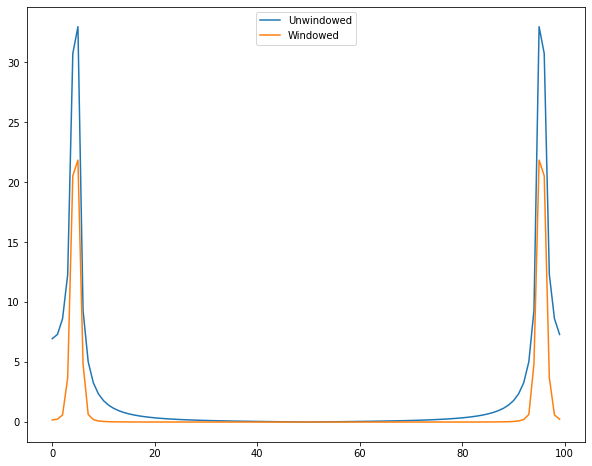

In [233]:
f_fft = np.fft.fft(f)
f_win_fft = np.fft.fft(f*window)
plt.figure(figsize=(10,8))
plt.plot(np.abs(f_fft),label='Unwindowed')
plt.plot(np.abs(f_win_fft),label='Windowed')
plt.legend()
plt.show()

### Problem 5 - Matched Filter for LIGO

### Let's start finding the Gravitational Waves from LIGO dataset

In [238]:
# Importing Necessary Functions

import warnings
warnings.filterwarnings('ignore')

import time
import h5py
import glob
import scipy
import numpy as np
from scipy import signal
from scipy.integrate import quad
from matplotlib import pyplot as plt

In [240]:
# Function to read our model / template

def read_template(filename):
    file = h5py.File('Ligo Data/'+ filename,'r')
    template = file['template']
    tp = template[0]
    tx = template[1]
    
    return tp,tx

# Function to read our strain data

def read_file(filename):
    file = h5py.File('Ligo Data/'+ filename,'r')
    dqInfo = file['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    meta = file['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = file['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    file.close()
    
    return strain,dt,utc

# Let's have the list of data and template names

templates = ['GW150914_4_template.hdf5','LVT151012_4_template.hdf5','GW151226_4_template.hdf5','GW170104_4_template.hdf5']
H_data = ['H-H1_LOSC_4_V2-1126259446-32.hdf5','H-H1_LOSC_4_V2-1128678884-32.hdf5','H-H1_LOSC_4_V2-1135136334-32.hdf5','H-H1_LOSC_4_V1-1167559920-32.hdf5']
L_data = ['L-L1_LOSC_4_V2-1126259446-32.hdf5','L-L1_LOSC_4_V2-1128678884-32.hdf5','L-L1_LOSC_4_V2-1135136334-32.hdf5','L-L1_LOSC_4_V1-1167559920-32.hdf5']

### (a) Noise Models for the Livingston and Hanford Detectors

We come up with the noise model from the following steps:

1. Read the data and template files

2. Multiply the data and template with a window function to prevent spectral leakage and make the edges go to zero. As we wanted a window function that has an extended flat period near the center to avoid tapering of the data, we use 'Tukey' window function which is just a tapered cosine function and looks like,

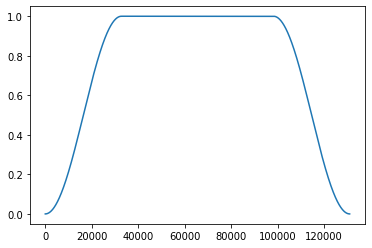

3. Take the Fourier Transform of the windowed data and template. 

4. Find the Power Spectrum by taking the absolute value of the fourier transform squared (i.e),
$$ \text{Power Spectrum} = |\text{F.T}(\text{data})|^2 $$
5. Finally, smooth the power spectrum to remove the high frequency lines! We do this by convolving the power spectrum with a gaussian kernal

In [364]:
def smooth_fun(vec,sigma):
    
    x = np.fft.fftfreq(len(vec))*len(vec)
    kernal = np.exp(-0.5*x**2/sigma**2)   # Making a Gaussian Kernal
    kernal = kernal / kernal.sum()
    kernal_fft = np.fft.rfft(kernal)
    vec_fft = np.fft.rfft(vec)
    return np.fft.irfft(kernal_fft*vec_fft)  # Convolving the data with the kernal
  
def noise_model(H_file,L_file,template,plot=True):

    # Reading the data and template files
    strain_H, dt_H, utc_H = read_file(H_file)   # Hanford data
    strain_L, dt_L, utc_L = read_file(L_file)   # Livingston data
    tp, tx = read_template(template)

    # We begin by assuming our noise to be stationary as we see that the noise is not changing with time. 
    # Now, to see the noise of a stationary signal, we do fourier transform first!
    # But, the FFT assumes that the data is continuous, which in this case is not. Hence we do windowing here...
    # And make the edges go to zero, before performing fourier transform
    # We use 'Tukey' window function that creates a window with a extended flat period near the center
    window = signal.windows.tukey(len(strain_H))   
    
    strain_H_win = np.fft.rfft(strain_H * window)
    strain_L_win = np.fft.rfft(strain_L * window)
    template_win = np.fft.rfft(tp * window)

    # To get the real frequency range
    total_time = len(strain_H)*dt_H  # The total observation time for Hanford and Livingston Detector
    # Since we are measuring 32 seconds of data, the k=1 mode would be 1/32. This would be our spacing in frequency
    dν = 1/total_time
    ν_vec = np.arange(len(np.fft.rfft(strain_H)))* dν
    
    # The Power Spectrum is...
    ps_H = np.abs(np.fft.fft(strain_H * window))**2      
    ps_L = np.abs(np.fft.fft(strain_L * window))**2
    
    # Finally, let's do smoothing of power spectrum to remove the high frequency noise
    psH_smooth = smooth_fun(ps_H,2)
    psH_smooth = psH_smooth[:len(strain_H)//2+1] 
    
    psL_smooth = smooth_fun(ps_L,2)
    psL_smooth = psL_smooth[:len(strain_L)//2+1] 
    
    if plot is True:
        print('Before Windowing')
        plt.figure(figsize=(10, 8))
        plt.loglog(ν_vec, np.abs(np.fft.rfft(strain_H)),'r')
        plt.loglog(ν_vec, np.abs(np.fft.rfft(strain_L)),'g')
        plt.legend(['Hanford','Livingston'])
        plt.title(template.split('_')[0])
        plt.show()
   
        print('After Windowing')
        plt.figure(figsize=(10, 8))
        plt.loglog(ν_vec, np.abs(strain_H_win),'r')
        plt.loglog(ν_vec, np.abs(strain_L_win),'g')
        plt.legend(['Hanford','Livingston'])
        plt.title(template.split('_')[0])
        plt.show()

        print('Smoothed Power Spectrum')
        plt.figure(figsize=(10, 8))
        plt.grid('on')
        plt.loglog(ν_vec, psH_smooth,'r')
        plt.loglog(ν_vec, psL_smooth,'g')
        plt.legend(['Hanford','Livingston'])
        plt.title(template.split('_')[0])
        plt.show()

    return strain_H_win, strain_L_win, template_win, psH_smooth, psL_smooth

Before Windowing


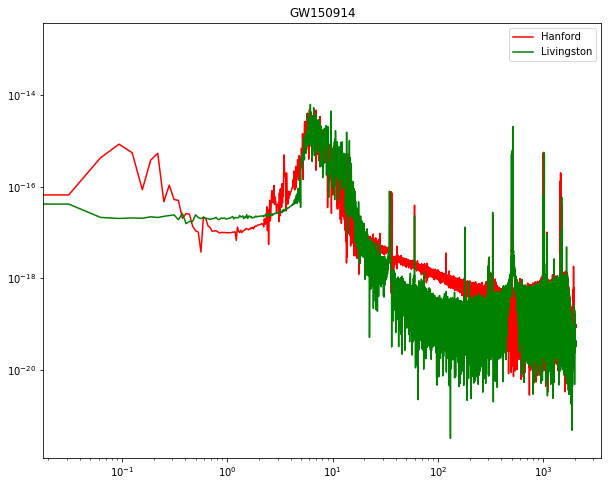

After Windowing


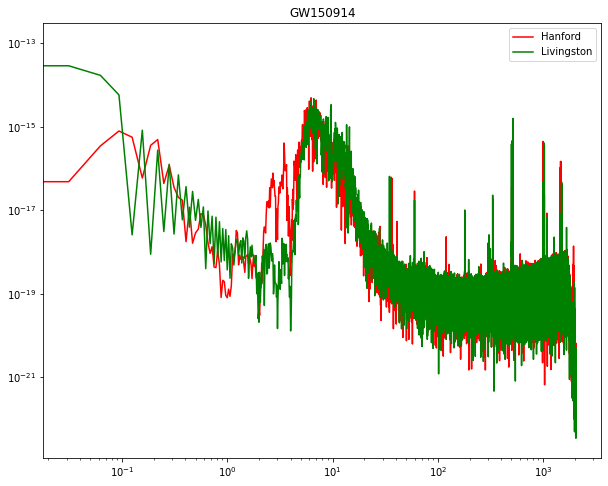

Smoothed Power Spectrum


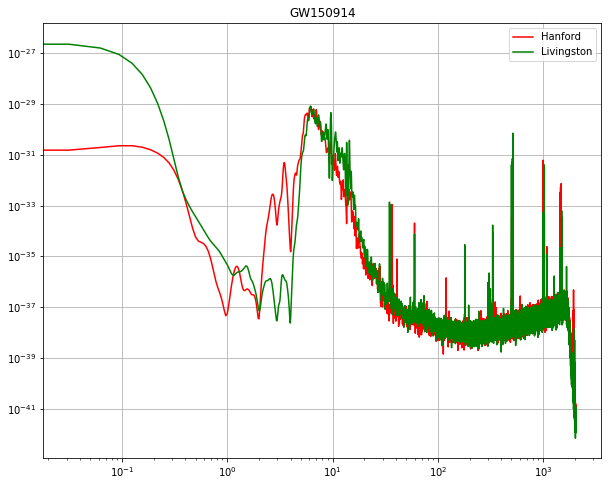

In [365]:
# # Let see this in action by considering the 1st template and the 1st Hanford and Livingston data here!

strain_H_win, strain_L_win, template_win, psH_smooth, psL_smooth = noise_model(H_data[0],L_data[0],templates[0])

### (b) Performing Matched Filter to search the 4 events

From the linear least squares, we have

$$ A^T * N^{-1} * A * m = A^T * N^{-1} * d $$

Since our noise is stationary, we can rewrite the above equation as,

$$ (A^T * N^{-1/2}) * 1 * (N^{-1/2} * A) * m = (A^T * N^{-1/2}) * 1 * (N^{-1/2} * d) $$

$$ (N^{-1/2} * A)^T * 1 * (N^{-1/2} * A) * m = (N^{-1/2} * A)^T * 1 * (N^{-1/2} * d) $$

$$ \tilde{A}^T * \tilde{A} * m =  \tilde{A}^T * \tilde{d}     $$

where $\tilde{A}$ = $N^{-1/2} * A $ and $\tilde{d}$ = $N^{-1/2} * d $. Through this procedure, we have whitened our noise.

Now, the matched filter output would just be,

$$ m =  \frac{\tilde{A}^T \star d}{\tilde{A}^T * \tilde{A}} $$

In [366]:
def matched_filter(fun,H_file,L_file,template):
    
    strain_H_win, strain_L_win, template_win, psH_smooth, psL_smooth = fun(H_file,L_file,template,False)

    # Let's Whiten the data and template

    strain_H_white = strain_H_win / np.sqrt(psH_smooth)            # N^(-1/2) * d
    strain_L_white = strain_L_win / np.sqrt(psL_smooth)  

    template_H_white = template_win / np.sqrt(psH_smooth)          # N^(-1/2) * A
    template_L_white = template_win / np.sqrt(psL_smooth) 

    # Since, we whitened our data and template

    lhs_H = (template_H_white * np.conj(template_H_white)).sum()            # A^T * A
    rhs_H = np.fft.irfft(strain_H_white * np.conj(template_H_white))   # A^T * d

    lhs_L = (template_L_white * np.conj(template_L_white)).sum()            # A^T * A
    rhs_L = np.fft.irfft(strain_L_white * np.conj(template_L_white))   # A^T * d

    mf_H = rhs_H / lhs_H
    mf_L = rhs_L / lhs_L

    return mf_H, mf_L

For the Event GW150914
The Matched Filter output for both the detectors are


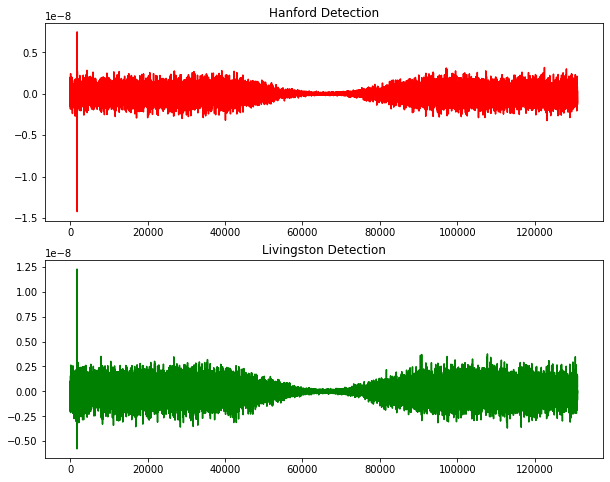

For the Event LVT151012
The Matched Filter output for both the detectors are


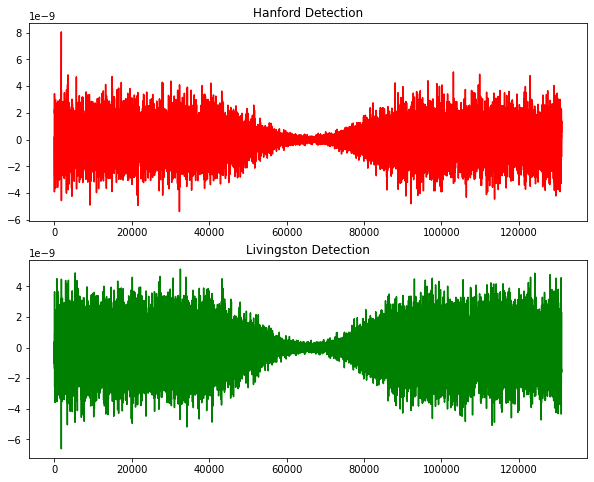

For the Event GW151226
The Matched Filter output for both the detectors are


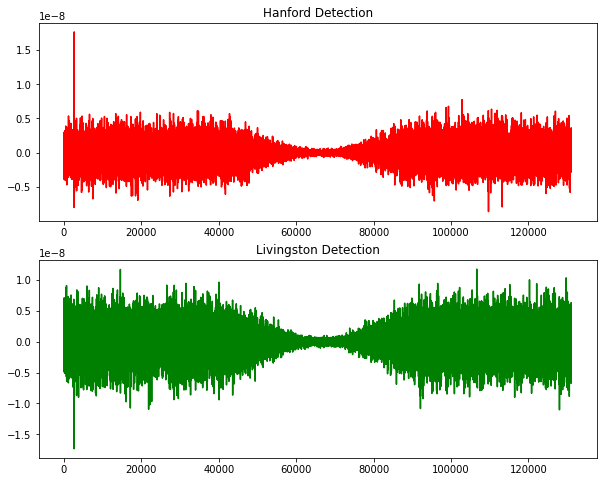

For the Event GW170104
The Matched Filter output for both the detectors are


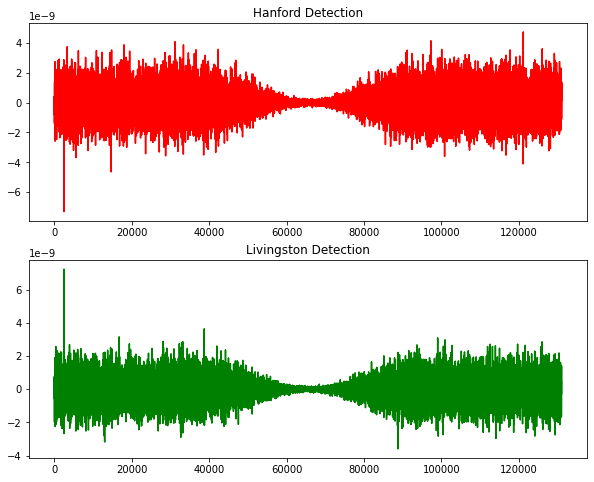

In [367]:
# Let's see this in action for all the 4 sets of event 

hanford_mfs = []
livingston_mfs = []

for i in range(4):
    
    print('For the Event',templates[i].split('_')[0])
    print('The Matched Filter output for both the detectors are')
    mf_H, mf_L = matched_filter(noise_model,H_data[i],L_data[i],templates[i])
    hanford_mfs.append(mf_H)
    livingston_mfs.append(mf_L)
    
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(mf_H,'r')
    axs[0].set_title('Hanford Detection')
    axs[1].plot(mf_L,'g')
    axs[1].set_title('Livingston Detection')
    plt.show()

The spike seen in each event corresponds to the shift in time between where the template is and where the signal in the data is.

### (c) Estimating Noise and SNR for each event analytically

We know that from Least squares, the noise is given by

$$ \frac{1}{\sqrt{A^T * N^{-1} * A}} $$

In [415]:
def noise(H_data,L_data,template,hanford_mfs,livingston_mfs):
    
    strain_H_win, strain_L_win, template_win, psH_smooth, psL_smooth = noise_model(H_data,L_data,template,False)
    
    # This is our noise from the template and noise model
    hanford_N    = np.sqrt(np.abs(1/(template_win * (1/psH_smooth) * np.conj(template_win)).sum()))  
    livingston_N = np.sqrt(np.abs(1/(template_win * (1/psL_smooth) * np.conj(template_win)).sum()))
    
    # This is our signal from the matched filter output
    hanford_S   = max(np.abs(hanford_mfs))*1e5
    livington_S = max(np.abs(livingston_mfs))*1e5
    
    SNR_H = hanford_S/hanford_N        # This is our SNR
    SNR_L = livington_S/livingston_N
    
    # To determine the combined SNR from Hanford + Livingston detectors...
    # We do sum in quadrature by taking the square root of the sum of the squares of individual detector's SNR 
    SNR_H_L = np.sqrt(SNR_H **2 + SNR_L **2 )

    return SNR_H , SNR_L, SNR_H_L   

for i in range(4):
    a,b,c = noise(H_data[i],L_data[i],templates[i],hanford_mfs[i],livingston_mfs[i])
    print('\nThe SNR for the event',templates[i].split('_')[0],'from Hanford detector is',a,
          'and from Livingston Detector is',b) 
    print('The combined SNR from Hanford + Livingston is',c)


The SNR for the event GW150914 from Hanford detector is 19.766222153539573 and from Livingston Detector is 14.892540383164862
The combined SNR from Hanford + Livingston is 24.748561519556542

The SNR for the event LVT151012 from Hanford detector is 7.576730507258357 and from Livingston Detector is 5.577936672280058
The combined SNR from Hanford + Livingston is 9.408518624076066

The SNR for the event GW151226 from Hanford detector is 11.375037484974941 and from Livingston Detector is 7.7670671643652645
The combined SNR from Hanford + Livingston is 13.773845146521218

The SNR for the event GW170104 from Hanford detector is 8.450534590680592 and from Livingston Detector is 10.532229343546271
The combined SNR from Hanford + Livingston is 13.503310327965744


### (d) SNR from the scatter in the Matched Filter

In [416]:
# We determine the noise by just taking the standard deviation of the matched filter output

for i in range(4):
    mf_H, mf_L = matched_filter(noise_model,H_data[i],L_data[i],templates[i])

    # We determine the SNR by dividing the signal with the standard deviation of the matched filter output
    SNR_H = np.max(np.abs(mf_H)) / np.std(mf_H)
    SNR_L = np.max(np.abs(mf_L)) / np.std(mf_L)
    SNR_H_L = np.sqrt(SNR_H **2 + SNR_L **2 )
    
    print('\nThe SNR for the event',templates[i].split('_')[0],'from Hanford detector is',SNR_H,'and from Livingston Detector is',SNR_L) 
    print('The combined SNR from Hanford + Livingston is',SNR_H_L)


The SNR for the event GW150914 from Hanford detector is 19.49778962898589 and from Livingston Detector is 14.734548517428792
The combined SNR from Hanford + Livingston is 24.439122742616043

The SNR for the event LVT151012 from Hanford detector is 7.498351151432275 and from Livingston Detector is 5.525237553730722
The combined SNR from Hanford + Livingston is 9.314156967506076

The SNR for the event GW151226 from Hanford detector is 11.289353105921299 and from Livingston Detector is 7.68044131194224
The combined SNR from Hanford + Livingston is 13.654254732366901

The SNR for the event GW170104 from Hanford detector is 8.361917137501209 and from Livingston Detector is 10.368046233639818
The combined SNR from Hanford + Livingston is 13.319836369765554


The SNR obtained analytically and from the scatter of the matched filter agrees with each other

### (e) Frequency where half the weight comes above that and half below

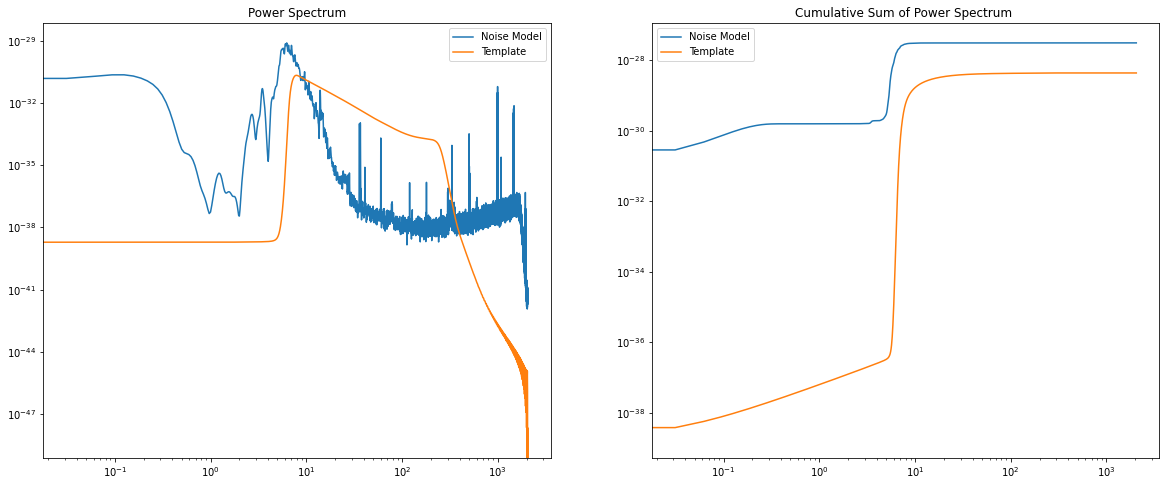

In [442]:
# Let's take the power spectrum of both the data and template and see...
# Reading the 1st data and template files...
strain_H, dt_H, utc_H = read_file(H_data[0])   # Hanford data
strain_L, dt_L, utc_L = read_file(L_data[0])   # Livingston data
tp, tx = read_template(templates[0])           # Template

window = signal.windows.tukey(len(strain_H))   # Our Window Function

# The Power Spectrum is...
ps_H = np.abs(np.fft.fft(strain_H * window))**2      
ps_L = np.abs(np.fft.fft(strain_L * window))**2
ps_T = np.abs(np.fft.fft(tp * window))**2

# Finally, let's do smoothing of power spectrum to remove the high frequency noise
psH_smooth = smooth_fun(ps_H,2)
psH_smooth = psH_smooth[:len(strain_H)//2+1] 

psL_smooth = smooth_fun(ps_L,2)
psL_smooth = psL_smooth[:len(strain_L)//2+1] 

temp_smooth = smooth_fun(ps_T,2)
temp_smooth = temp_smooth[:len(tp)//2+1] 

# To get the real frequency range
total_time = len(strain_H)*dt_H  # The total observation time for Hanford and Livingston Detector
# Since we are measuring 32 seconds of data, the k=1 mode would be 1/32. This would be our spacing in frequency
dν = 1/total_time
ν_vec = np.arange(len(np.fft.rfft(strain_H)))* dν

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.loglog(ν_vec,psH_smooth)
plt.loglog(ν_vec,temp_smooth)
plt.legend(['Noise Model','Template'])
plt.title('Power Spectrum')

plt.subplot(1,2,2)
plt.loglog(ν_vec,np.cumsum(psH_smooth))  # We take the cumulative sum of the power spectrum here...
plt.loglog(ν_vec,np.cumsum(temp_smooth))
plt.title('Cumulative Sum of Power Spectrum ')
plt.legend(['Noise Model','Template'])
plt.show()

We see that the cumulative sum of the power spectrum goes flat at about a frequency of 10 Hz and the power spectrums of the template and noise model intersect at 10 Hz. Hence the frequency is 10 where half the power comes from above and half below.

### (f) Localising the Time of Arrival

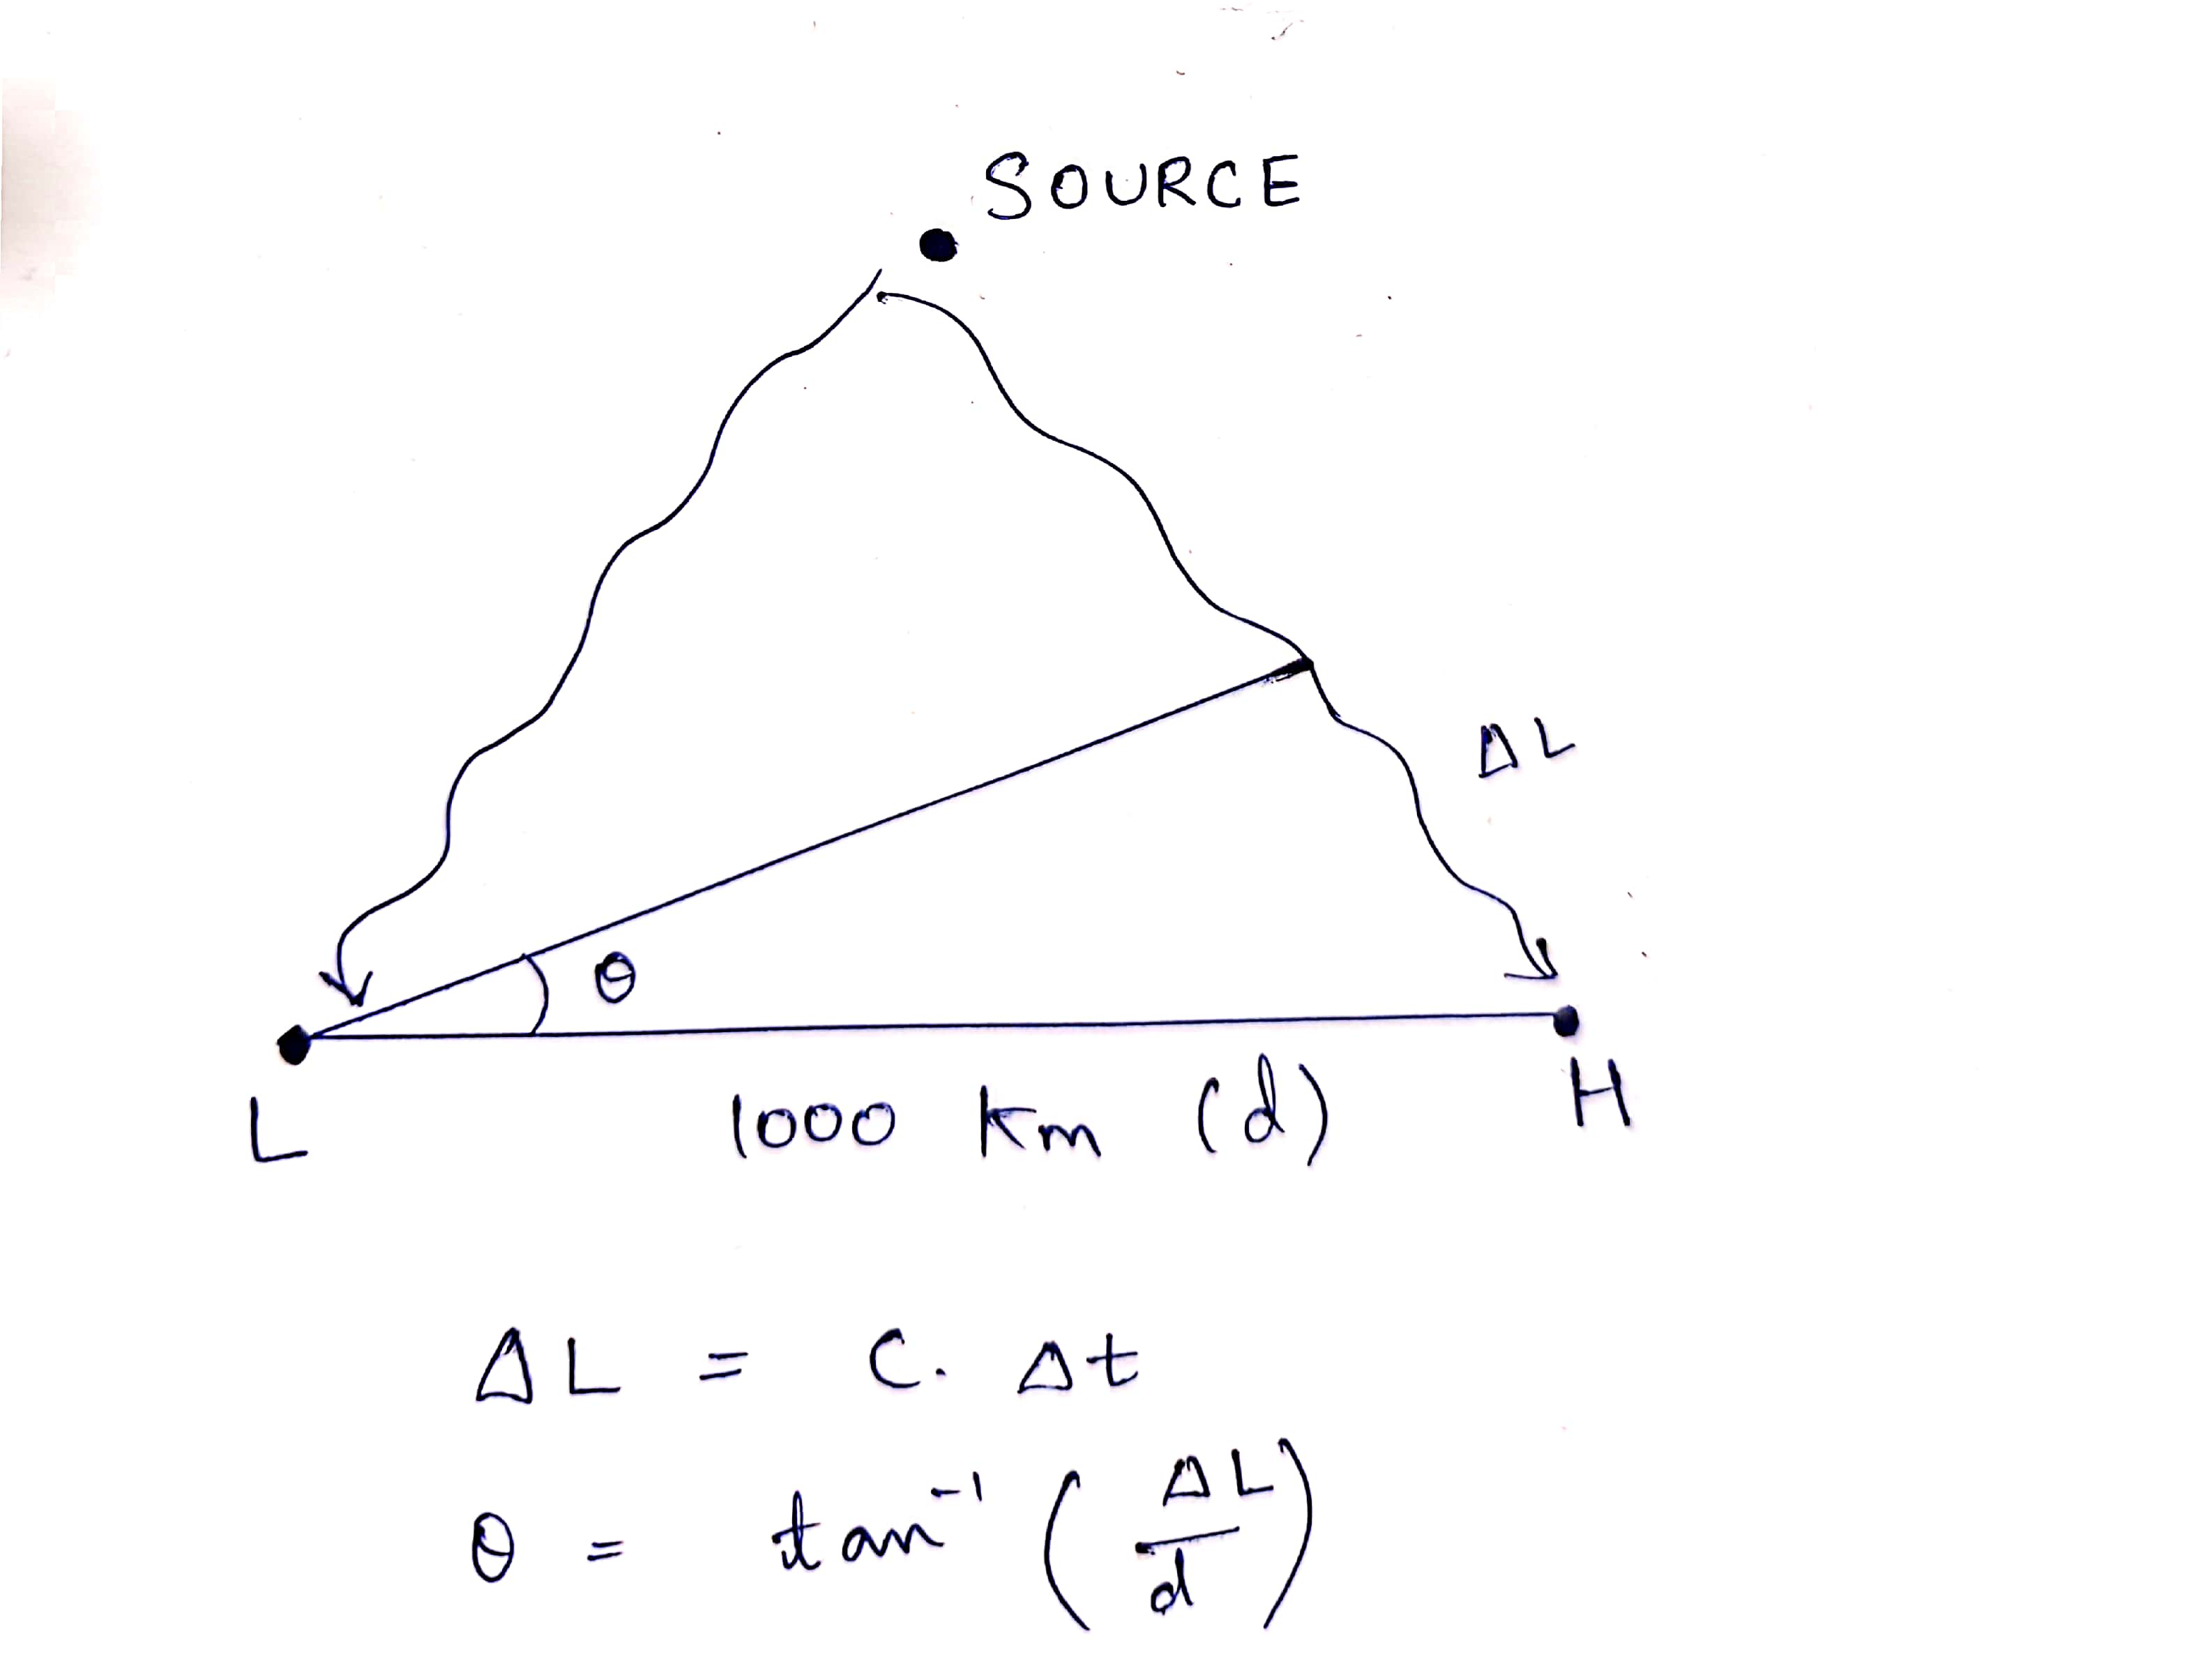

In [504]:
# We can use the horizontal shift in our matched filter output to calculate the time of arrival
import math

strain_H, dt_H, utc_H = read_file(H_data[0])   # Hanford data
strain_L, dt_L, utc_L = read_file(L_data[0])   # Livingston data

h = strain_H.tolist().index(strain_H[(np.argmax(np.abs(hanford_mfs[0])))])
l = strain_L.tolist().index(strain_L[(np.argmax(np.abs(livingston_mfs[0])))])

distance = 1000
δL = 3 * 10**8 * (h-l)
θ = math.atan(δL / distance)

print('The Positional Uncertainty for the event',templates[0].split('_')[0],'is',θ)

The Positional Uncertainty for the event GW150914 is 1.5707962156837856
